# Exploratory Data Analysis

In [11]:
# 1 Setup ───────────────────────────────────────────────────────────────────────
import pathlib, urllib.request, zipfile, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

plt.style.use("default")
sns.set_context("notebook")

DATA_DIR = pathlib.Path("../data/students")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# 2 Download & load ────────────────────────────────────────────────────────────
UCI_URL = "https://archive.ics.uci.edu/static/public/320/student+performance.zip"

print("Downloading and extracting...")

# Download and extract the main zip file
with urllib.request.urlopen(UCI_URL) as resp:
    with zipfile.ZipFile(io.BytesIO(resp.read())) as zf:
        zf.extractall(DATA_DIR)

# Now let's check what we have
print("\nFiles in data directory:")
for file in DATA_DIR.glob("*"):
    print(f"- {file.name}")
    # If we find any zip files, extract them
    if file.suffix == '.zip':
        print(f"Extracting {file.name}...")
        with zipfile.ZipFile(file) as zf:
            zf.extractall(DATA_DIR)
        # Remove the zip file after extraction
        file.unlink()

print("\nFinal contents of data directory:")
for file in DATA_DIR.glob("*"):
    print(f"- {file.name}")



Files in data directory:
- .student.zip_old
- student.zip
Extracting student.zip...

Final contents of data directory:
- student-por.csv
- student-merge.R
- .student.zip_old
- student-mat.csv
- student.txt


In [ ]:
math_df = pd.read_csv(DATA_DIR / "student-mat.csv", sep=";")
por_df  = pd.read_csv(DATA_DIR / "student-por.csv", sep=";")

# add course tag before concatenation
math_df["course"] = "math"
por_df["course"]  = "por"

students = pd.concat([math_df, por_df], ignore_index=True)

print(f"Combined shape: {students.shape}")

students.head()

Combined shape: (1044, 34)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,course
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,math
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,math
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,math
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,math
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,math


In [13]:
# 3 Feature engineering ────────────────────────────────────────────────────────
# Create binary target: pass if final grade (G3) ≥ 10 out of 20
students["pass"] = (students["G3"] >= 10).astype(int)

# Drop raw grade columns to make prediction "harder"
students = students.drop(columns=["G1", "G2", "G3"])

print(students["pass"].value_counts())


pass
1    814
0    230
Name: count, dtype: int64


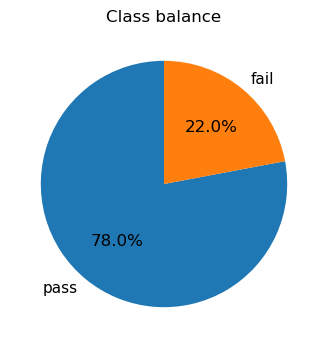

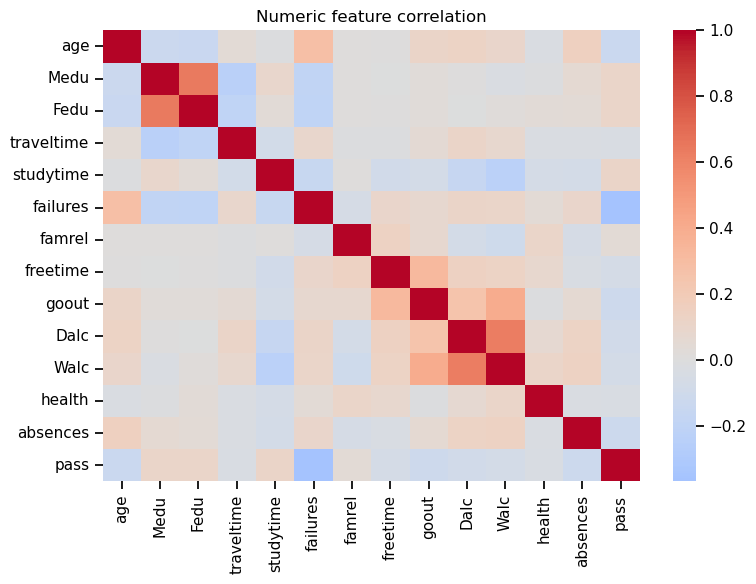

In [15]:
# 4 Exploratory plots ─────────────────────────────────────────────────────────
plt.figure(figsize=(4, 4))
students["pass"].value_counts().plot.pie(
    labels=["pass", "fail"], autopct="%1.1f%%", startangle=90
)
plt.title("Class balance")
plt.ylabel("")
plt.show()

# Numerical correlation heat-map
num_cols = students.select_dtypes("number").columns
plt.figure(figsize=(8, 6))
sns.heatmap(students[num_cols].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Numeric feature correlation")
plt.tight_layout()


In [16]:
# 5 Baseline model ────────────────────────────────────────────────────────────
X = students.drop(columns="pass")
y = students["pass"]

# Identify categorical vs numeric columns
cat_cols = X.select_dtypes("object").columns.tolist()
num_cols = X.select_dtypes("number").columns.tolist()

preprocess = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="passthrough"
)

clf = Pipeline(
    steps=[
        ("prep", preprocess),
        ("logreg", LogisticRegression(max_iter=1000, solver="lbfgs"))
    ]
)

scores = cross_val_score(clf, X, y, cv=5, scoring="roc_auc")
print(f"Baseline ROC-AUC (5-fold): {scores.mean():.3f} ± {scores.std():.3f}")


Baseline ROC-AUC (5-fold): 0.709 ± 0.076


In [17]:
# 6 Train/test split & report ────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Fail", "Pass"]))

# Optional ROC-AUC on hold-out
y_proba = clf.predict_proba(X_test)[:, 1]
print("Hold-out ROC-AUC:", roc_auc_score(y_test, y_proba).round(3))


              precision    recall  f1-score   support

        Fail       0.46      0.24      0.31        46
        Pass       0.81      0.92      0.86       163

    accuracy                           0.77       209
   macro avg       0.63      0.58      0.59       209
weighted avg       0.73      0.77      0.74       209

Hold-out ROC-AUC: 0.733


In [18]:
# 7 Save clean dataset for later notebooks ────────────────────────────────────
CLEAN_PATH = DATA_DIR / "students_clean.csv"

students.to_csv(CLEAN_PATH, index=False)

print("Saved:", CLEAN_PATH.relative_to(DATA_DIR.parent))


Saved: students/students_clean.csv


At this point, I have some sense of the data.
However I would like to explore it more. To do so, I will be creating a hold-out test set now and never peeking at it again.
This is the single best safeguard against “optimism bias”.

In [19]:
# 8 Save train/test splits for later notebooks ─────────────────────────────────

# Re-attach target column for easy CSV export
train_df = X_train.copy()
train_df["pass"] = y_train
test_df  = X_test.copy()
test_df["pass"]  = y_test

DATA_DIR = pathlib.Path("../data/students")
train_path = DATA_DIR / "students_train.csv"
test_path  = DATA_DIR / "students_test.csv"

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path,  index=False)

print(f"Saved {train_path.relative_to(DATA_DIR.parent)}  ({len(train_df)} rows)")
print(f"Saved {test_path.relative_to(DATA_DIR.parent)}   ({len(test_df)} rows)")

Saved students/students_train.csv  (835 rows)
Saved students/students_test.csv   (209 rows)
